# Kaggle Freesound Challenge

An implementation of Fastai to classify general-purpose audio clips. Required the modification of Fastai's `dataset.py`, `transforms.py`, and `resnet.py`, as these were designed for images, not audio.

In [33]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os
from audio_dataset import *
from audio_transforms import *
from td_resnet import *

import IPython.display as ipd

In [34]:
import librosa
from librosa import display

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [5]:
verified = list(trn['manually_verified'])

In [6]:
trn = trn[['fname','label']].copy()
trn_sample = trn[:1900]
trn.head()

,fname,label
0,00044347.wav,Hi-hat
1,001ca53d.wav,Saxophone
2,002d256b.wav,Trumpet
3,0033e230.wav,Glockenspiel
4,00353774.wav,Cello


In [ ]:
trn.to_csv('trn.csv', index=False)
trn_sample.to_csv('trn_sample.csv', index=False)

In [26]:
trn.shape[0], len(trn.label.unique())

(9473, 41)

In [27]:
fnames = list(trn['fname']) 
test_fnames = list(test['fname']) 
len(fnames), len(test_fnames)

(9473, 9400)

In [28]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [7]:
stats = (np.array([ 0.18637]), np.array([ 0.30634]))

### Listen to Sounds

In [30]:
test_preds = list(test.label[:10])

In [ ]:
length= int(3*44100) #seconds * sample_rate
n = 4

#play sample with stats
#length = 3*44100
#sample = os.path.join(TRN_PATH, fnames[n])
sample = os.path.join(TEST_PATH, test_fnames[n])
print(test_fnames[n])
raw = open_audio(sample)
raw_len = len(raw)
raw_s = adj_length(raw, length)
#print('raw length: ', raw_len, 'sample length:', len(raw_s))
#print('label:', trn['label'].iloc[n], 'verified:', verified[n])
print('prediction:', test_preds[n])
ipd.Audio(raw_s, rate=44100)

### Model

In [35]:
# from teammate John Hartquist
def mapk_np(preds, targs, k=3):
    preds = np.argsort(-preds, axis=1)[:, :k]
    score = 0.0
    for i in range(k):
        num_hits = (preds[:, i] == targs).sum()
        score += num_hits * (1.0 / (i+1.0))
    score /= preds.shape[0]
    return score

def mapk(preds, targs, k=3):
    return mapk_np(to_np(preds), to_np(targs), k)

In [40]:
tfms = aud_tfms_from_stats(stats, aug_tfms=[RandomLighting(0.5,0.5)])
md = AudioClassifierData.from_csv(PATH, 'audio_train', 'trn.csv', val_idxs=1, 
                                  bs=32, tfms=tfms, test_name='audio_test')

In [41]:
m = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=41, vgg_head=False)
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy
learn = ConvLearner.from_model_data(m, md, crit=loss, metrics=metrics, opt_fn=opt)

In [42]:
learn.unfreeze()

In [43]:
learn.lr_find()

 76%|███████▌  | 224/296 [08:32<02:44,  2.29s/it, loss=13]  

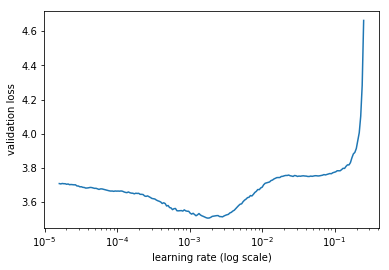

In [44]:
learn.sched.plot()

In [ ]:
learn.fit(1e-4, 1, wds=1e-5, cycle_len=20, use_clr_beta=(5,20,0.95,0.75))

In [59]:
learn.save('2d_res_1ch_h256_10s_1')

In [ ]:
learn.load('2d_res_1ch_h256_10s_1')

### Model Evaluation

In [41]:
learn.model.eval()
val_preds = learn.predict_with_targs()

val_acc = accuracy_np(*val_preds)
val_map = mapk_np(*val_preds)

print(f'Val Acc: {val_acc:.3f}, Val MAP: {val_map:.3f}')

Val Acc: 0.697, Val MAP: 0.770


### Predictions

In [60]:
multi_preds, y = learn.TTA(is_test=True)

In [61]:
preds = np.mean(multi_preds, 0)

In [62]:
np.save(PATH/'tmp/preds14.npy', preds)

In [63]:
classes = np.array(sorted(trn.label.unique()))
top_3_idx = [np.argsort(preds[i])[-3:][::-1] for i in range(len(test_fnames))]
pred_labels = [list(classes[[top_3_idx[i]]]) for i in range(len(test_fnames))]
preds = [" ".join(ls) for ls in pred_labels]
preds[:5]

['Trumpet Saxophone Oboe',
 'Hi-hat Chime Shatter',
 'Cello Double_bass Acoustic_guitar',
 'Trumpet Violin_or_fiddle Meow',
 'Bass_drum Knock Gunshot_or_gunfire']

In [64]:
tested = [md.test_ds.fnames[i].split('/')[-1] for i in range(len(test_fnames))]

In [65]:
idx = []
for fname in test_fnames:
    for name in tested:
        if name == fname:
            idx.append(tested.index(name))

In [66]:
[tested[i] for i in idx[:5]]

['00063640.wav',
 '0013a1db.wav',
 '002bb878.wav',
 '002d392d.wav',
 '00326aa9.wav']

In [67]:
test_fnames[:5]

['00063640.wav',
 '0013a1db.wav',
 '002bb878.wav',
 '002d392d.wav',
 '00326aa9.wav']

In [68]:
test['label'] = [preds[i] for i in idx]

In [69]:
test.head()

,fname,label
0,00063640.wav,Shatter Tearing Fireworks
1,0013a1db.wav,Flute Oboe Trumpet
2,002bb878.wav,Bass_drum Computer_keyboard Knock
3,002d392d.wav,Bass_drum Flute Cello
4,00326aa9.wav,Oboe Clarinet Telephone


In [70]:
test.to_csv(PATH/'tmp/sub13.csv', index=False)

In [71]:
test.shape

(9400, 2)